<a href="https://colab.research.google.com/github/HazemAbdo/FloodSense/blob/classification%2Fdeep_learning/SI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Resources:
* https://arxiv.org/pdf/1909.00125.pdf

# Imports

In [18]:
import zipfile
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from skimage.feature import hog,local_binary_pattern
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report,accuracy_score

In [2]:
!pip install opencv-python-headless
!pip install tqdm
#tqdm is a Python package that provides a progress bar for iterative tasks
from tqdm import tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Helpers

In [4]:
def show_img(img,title=""):
   plt.imshow(img)
   plt.title(title)
   plt.show()

In [5]:
def extract_file(zip_path,specified_directory):
  # create a ZipFile object
  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  # extract all contents to a specified directory
    zip_ref.extractall(specified_directory)


In [6]:
def read_images( flooded_path,non_flooded_path,image_size):
    #create empty numpy arrays to store the images
    flooded = np.empty((0, 224, 224))
    non_flooded = np.empty((0, 224, 224))

    # loop through the images in the "flooded" folder
    for filename in os.listdir(flooded_path):
        img = cv2.imread(os.path.join(flooded_path, filename), cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (224, 224)) # resize the image to (224, 224)
        img = img.astype('float32') / 255.0  # normalize pixel values to the range of [0, 1]
        img = np.expand_dims(img, axis=0) # add an extra dimension for concatenation
        flooded = np.concatenate((flooded, img), axis=0)

    # loop through the images in the "non-flooded" folder
    for filename in os.listdir(non_flooded_path):
        img = cv2.imread(os.path.join(non_flooded_path, filename), cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (224, 224)) # resize the image to (224, 224)
        img = img.astype('float32') / 255.0  # normalize pixel values to the range of [0, 1]
        img = np.expand_dims(img, axis=0) # add an extra dimension for concatenation
        non_flooded = np.concatenate((non_flooded, img), axis=0)
    return flooded,non_flooded


In [7]:
def show_images(images,images_labels):
  nrows = 4
  ncols = 4
  fig, ax = plt.subplots(nrows,ncols,figsize = (10,10))
  ax = ax.flatten()
  for i in range(nrows*ncols):
      pic = images[i%8]
      ax[i].imshow(pic,cmap='gray')
      ax[i].set_title(images_labels[i%8])
      ax[i].set_axis_off()
  plt.show()

# Images reading 

In [10]:
extract_file("drive/MyDrive/Copy of dataset.zip","/content")

In [11]:
flooded,non_flooded=read_images("dataset/flooded","dataset/non-flooded",224)
print("flooded images shapes",flooded.shape)
print("non_flooded images shapes",non_flooded.shape)

flooded images shapes (461, 224, 224)
non_flooded images shapes (461, 224, 224)


In [12]:
def split_data(shuffle=False,stratify=False):
  stratify_1=None
  stratify_2=None
  if stratify:
    stratify_1=y
    stratify_2=y_test

  # concatenate the flooded and non-flooded images into a single numpy array
  X = np.concatenate((flooded, non_flooded), axis=0)
  # create the corresponding labels
  y = np.concatenate((np.ones(flooded.shape[0]), np.zeros(non_flooded.shape[0])), axis=0)
  # 80% training, 10% validation, 10% testing
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=shuffle,stratify=stratify_1)
  X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5,shuffle=shuffle,stratify=stratify_2)
  return X_train, X_test,X_val, y_train, y_test,y_val

In [13]:
  X_train, X_test,X_val, y_train, y_test,y_val=split_data(shuffle=True)
  print(X_train.shape, y_train.shape)  # should output the shapes of the training data
  print(X_test.shape, y_test.shape)  # should output the shapes of the training data
  print(X_val.shape, y_val.shape)  # should output the shapes of the validation data

(737, 224, 224) (737,)
(93, 224, 224) (93,)
(92, 224, 224) (92,)


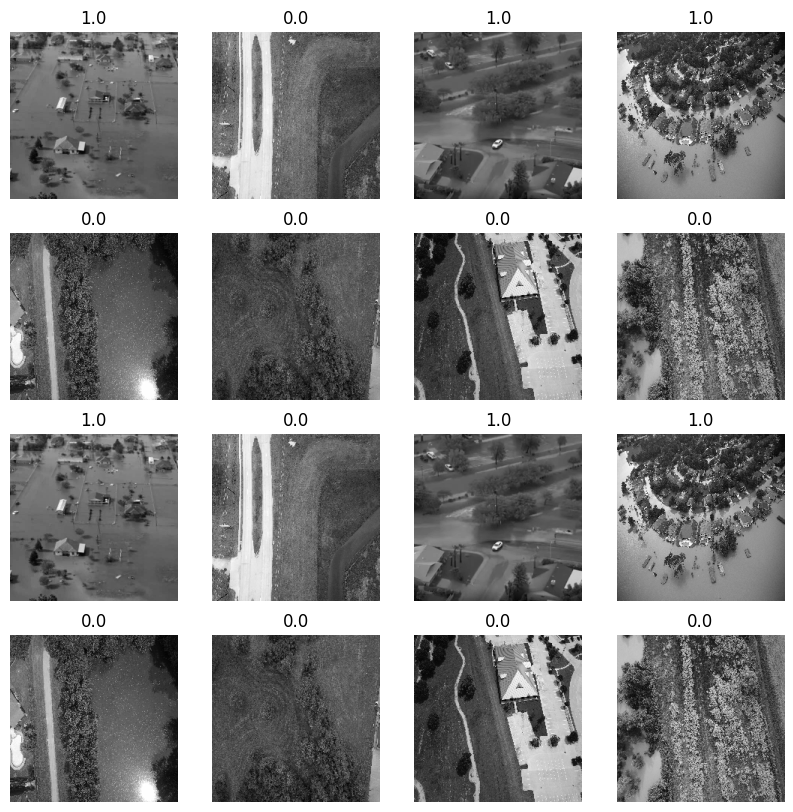

In [14]:
show_images(X_train,y_train)

# Machine-learning approach

## Feature Extraction

In [37]:
from skimage.feature import graycomatrix, graycoprops

def haralick(data_gray):
    data_haralick = []
    for i in range(len(data_gray)):
        # Convert the image to an unsigned integer format
        image_uint = (data_gray[i] * 255).astype(np.uint8)
        # Compute the gray-level co-occurrence matrix
        glcm = graycomatrix(image_uint, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
        # Compute the Haralick features
        haralick = np.array([graycoprops(glcm, prop).ravel()[0] for prop in ['contrast', 'homogeneity', 'energy', 'correlation']])
        data_haralick.append(haralick)
    data_haralick = np.array(data_haralick)
    return data_haralick

In [29]:
def lbp(data_gray):
  radius = 3
  n_points = 8 * radius
  data_lbp = []
  for i in range(len(data_gray)):
    lbp = local_binary_pattern(data_gray[i], n_points, radius)
    data_lbp.append(lbp.flatten())
  data_lbp = np.array(data_lbp)
  return data_lbp

In [30]:
def hog_func(data_gray):
    ppc = 16
    hog_images = []
    hog_features = []
    for image in data_gray:
        fd = hog(image, orientations=8, pixels_per_cell=(ppc,ppc),cells_per_block=(4, 4),block_norm= 'L2')
        hog_features.append(fd)
    hog_features = np.array(hog_features)
    return hog_features

In [38]:
train_features = np.concatenate((hog_func(X_train),lbp(X_train),haralick(X_train)),axis=1)
test_features = np.concatenate((hog_func(X_test),lbp(X_test),haralick(X_test)),axis=1)

In [39]:
print(train_features.shape)

(737, 65668)


## Models

In [40]:
# Define the parameter grid
param_grid = {'C': [0.1, 1, 10, 100]}

# Create the logistic regression model
log_reg = LogisticRegression()

# Create the GridSearchCV object with cross-validation data
model = GridSearchCV(log_reg, param_grid, cv=5)

# Fit the model to the training data
model.fit(train_features, y_train)

# Evaluate the model on the testing data
score = model.score(test_features, y_test)

print("Best parameter:", model.best_params_)
print("Accuracy:", score)

Best parameter: {'C': 0.1}
Accuracy: 0.6129032258064516


Best parameter: {'max_depth': 10, 'n_estimators': 100}
Accuracy: 0.7956989247311828


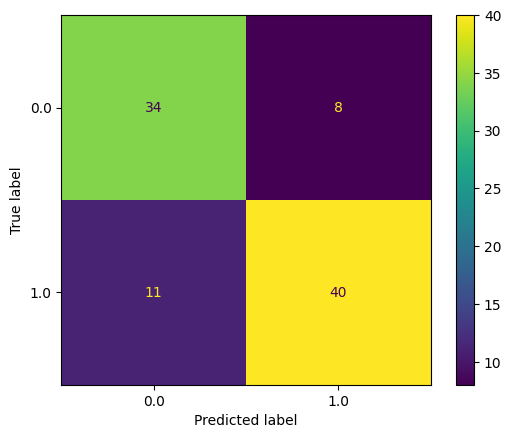

In [62]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay

# Define the parameter grid
param_grid = {'n_estimators': [10, 50, 100],
              'max_depth': [None, 5, 10, 20]}

# Create the Random Forest model
rf = RandomForestClassifier()

# Create the GridSearchCV object with cross-validation data
model = GridSearchCV(rf, param_grid, cv=5)

# Fit the model to the training data
model.fit(train_features, y_train)

# Evaluate the model on the testing data
score = model.score(test_features, y_test)

print("Best parameter:", model.best_params_)
print("Accuracy:", score)
ConfusionMatrixDisplay.from_estimator(model, test_features, y_test)

* SVM 
* Best parameters: {'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}
* Accuracy: 0.4731182795698925